In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import random
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')
from colossus.halo import concentration, mass_defs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from pylab import rcParams
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
rcParams['font.family'] = 'serif'
rc('text.latex',preamble=r'\usepackage{/Volumes/Extreme_SSD/codes/master_thesis/code/configs/apjfonts}')
from mpl_toolkits.axes_grid1 import make_axes_locatable
sz_ft = 18
sz_lb = 18
color_arr = ['indigo', 'royalblue', 'lightseagreen', 'darkgreen', 'goldenrod', 'darkred']
from tqdm import tqdm
import cosmo
import lensing_estimator
from cosmo import CosmoCalc
import lensing
import foregrounds as fg
import experiments as exp
import sims
import stats
import tools

In [2]:
nber_clus = 3000
nber_rand = 50000
nber_cov = 1000
nber_runs = 25
map_params = [180, 0.5, 180, 0.5]
noiseval = 2 # uK-arcmin
beamval = 1 # arcmin
l, cl = CosmoCalc().cmb_power_spectrum()
l, bl = exp.beam_power_spectrum(beam_fwhm = beamval)
l, nl = exp.white_noise_power_spectrum(noiseval_white = noiseval)
l, cl_noise =exp.white_noise_power_spectrum(noiseval_white = noiseval, beam_fwhm = beamval)
z = 0.7
cluster_2e14 = [2e14, cosmo.concentration_parameter(2e14, z, 0.674), z]
cluster_6e14 = [6e14, cosmo.concentration_parameter(6e14, z, 0.674), z]
cluster_10e14 = [10e14, cosmo.concentration_parameter(10e14, z, 0.674), z]
cluster_arr = [cluster_2e14, cluster_6e14, cluster_10e14]
mass_int = np.arange(0, 12, 0.1)

/Volumes/Extreme_SSD/codes/master_thesis/code/cosmo.py:98: RuntimeWarning: invalid value encountered in true_divide
  cl = dl * 2 * np.pi / (l*(l+1))


In [3]:
%%script false --no-raise-error

maps_rand = sims.cmb_mock_data(map_params, l, cl,  bl = bl, nl = nl, nber_obs = nber_rand)
stack_bg = lensing_estimator.stack(map_params, maps_rand, l = l, cl = cl, cl_noise = cl_noise)
del maps_rand
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_2uK-arcmin.npy', stack_bg)   

In [4]:
%%script false --no-raise-error

covariance_matrix, correlation_matrix = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, bl = bl, nl = nl, cl_noise = cl_noise)
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_2uK-arcmin.npy', covariance_matrix) 
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/correlation_matrix_3000clus_2uK-arcmin.npy', correlation_matrix) 

In [5]:
%%script false --no-raise-error

model_profiles = lensing_estimator.model_profiles(nber_clus, map_params, l, cl, mass_int, z, bl = bl, cl_noise = cl_noise)
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_0e14_12e14_0.1e14.npy', model_profiles) 

In [6]:
%%script false --no-raise-error

stack_bg = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_2uK-arcmin.npy')   
covariance_matrix = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_2uK-arcmin.npy')  
model_profiles = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_0e14_12e14_0.1e14.npy')    


lk_arr_2e14 = []      
lk_arr_6e14 = []  
lk_arr_10e14 = []  
for i in tqdm(range(nber_runs)):  
    maps_clus = sims.cmb_test_data(map_params, l, cl, cluster = cluster_arr, bl = bl, nl = nl, nber_obs = nber_clus, estimator_validation = True)
    maps_clus_2e14, maps_clus_6e14, maps_clus_10e14 = maps_clus[0], maps_clus[1], maps_clus[2]
    stack_clus_2e14 = lensing_estimator.stack(map_params, maps_clus_2e14, l = l, cl = cl, cl_noise = cl_noise)
    stack_clus_6e14 = lensing_estimator.stack(map_params, maps_clus_6e14, l = l, cl = cl, cl_noise = cl_noise)
    stack_clus_10e14 = lensing_estimator.stack(map_params, maps_clus_10e14, l = l, cl = cl, cl_noise = cl_noise)
    bins_2e14, lensing_dipole_profile_2e14, stack_dipole_2e14 = lensing_estimator.lensing_dipole(map_params, stack_clus_2e14, stack_bg)
    bins_6e14, lensing_dipole_profile_6e14, stack_dipole_6e14 = lensing_estimator.lensing_dipole(map_params, stack_clus_6e14, stack_bg)
    bins_10e14, lensing_dipole_profile_10e14, stack_dipole_10e14 = lensing_estimator.lensing_dipole(map_params, stack_clus_10e14, stack_bg)
    data_2e14 = bins_2e14, lensing_dipole_profile_2e14, covariance_matrix
    data_6e14 = bins_6e14, lensing_dipole_profile_6e14, covariance_matrix
    data_10e14 = bins_10e14, lensing_dipole_profile_10e14, covariance_matrix
   

    likelihood_2e14, _, _ = stats.run_ml(data_2e14, model_profiles, mass_int)
    mass_int_lk_2e14, lk_2e14 = likelihood_2e14
    likelihood_6e14, mass_6e14, error_6e14 = stats.run_ml(data_6e14, model_profiles, mass_int)
    mass_int_lk_6e14, lk_6e14 = likelihood_6e14
    likelihood_10e14, _, _ = stats.run_ml(data_10e14, model_profiles, mass_int)
    mass_int_lk_10e14, lk_10e14 = likelihood_10e14
    lk_arr_2e14.append(lk_2e14)
    lk_arr_6e14.append(lk_6e14)
    lk_arr_10e14.append(lk_10e14)

    del maps_clus
    del maps_clus_2e14
    del maps_clus_6e14
    del maps_clus_10e14

lk_arr_estimator_validation = [lk_arr_2e14, lk_arr_6e14, lk_arr_10e14]
for i, mass in enumerate([2, 6, 10]):
    np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_arr_estimator_validation_'+str(mass)+'e14.npy', lk_arr_estimator_validation[i]) 
    
comb_lk_2e14, mass_value_comb_lk_2e14, error_comb_lk_2e14 = stats.combined_likelihood(mass_int_lk_2e14, lk_arr_2e14)      
comb_lk_6e14, mass_value_comb_lk_6e14, error_comb_lk_6e14 = stats.combined_likelihood(mass_int_lk_6e14, lk_arr_6e14)      
comb_lk_10e14, mass_value_comb_lk_10e14, error_comb_lk_10e14 = stats.combined_likelihood(mass_int_lk_10e14, lk_arr_10e14)      
comb_lk_arr_estimator_validation = [comb_lk_2e14, comb_lk_6e14, comb_lk_10e14]
for i, mass in enumerate([2, 6, 10]):
    np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/comb_lk_estimator_validation_'+str(mass)+'e14.npy', comb_lk_arr_estimator_validation[i]) 

mass_results_estimator_validation = "{0:11.3f}{1:>1}{2:5.3f}".format(mass_value_comb_lk_2e14, "+-", error_comb_lk_2e14) + "\n"
mass_results_estimator_validation += "{0:11.3f}{1:>1}{2:5.3f}".format(mass_value_comb_lk_6e14, "+-", error_comb_lk_6e14) + "\n"          
mass_results_estimator_validation += "{0:11.3f}{1:>1}{2:5.3f}".format(mass_value_comb_lk_10e14, "+-", error_comb_lk_10e14) + "\n"
file = open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_results_estimator_validation.txt',"w")
file.write(mass_results_estimator_validation)
file.close()

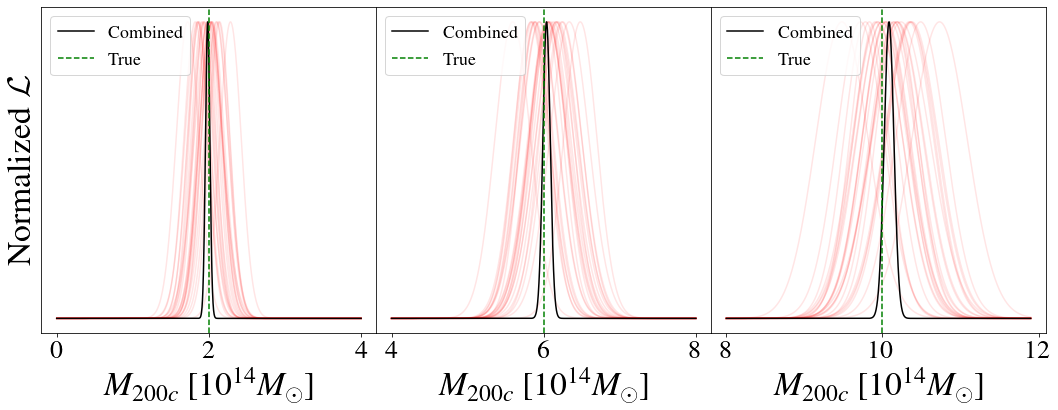

In [7]:
mass_int_finer = np.arange(min(mass_int), max(mass_int), 0.001) 


lk_arr_estimator_validation = []
comb_lk_arr_estimator_validation = []
for mass in [2, 6, 10]:
    lk = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_arr_estimator_validation_'+str(mass)+'e14.npy') 
    lk_arr_estimator_validation.append(lk)
    comb_lk = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/comb_lk_estimator_validation_'+str(mass)+'e14.npy')     
    comb_lk_arr_estimator_validation.append(comb_lk)
    
fig, ax_arr = plt.subplots(1, 3, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(18,6))

slices = [0, 4000, 8000, 12000]
true_values = [2, 6, 10]

for i, ax in enumerate(ax_arr):
    for j in range(nber_runs):
        ax.plot(mass_int_finer[slices[i]:slices[i+1]], lk_arr_estimator_validation[i][j][slices[i]:slices[i+1]], color = 'red', ls='-', alpha = 0.1)
    ax.plot(mass_int_finer[slices[i]:slices[i+1]], comb_lk_arr_estimator_validation[i][slices[i]:slices[i+1]], color = 'black', ls = '-', label = 'Combined')
    ax.tick_params(labelsize = sz_lb+8)
    ax.axvline(true_values[i], color = 'green', ls = '--', label = 'True') 
    ax.set_xlabel(r'$M_{200c} \ [10^{14}M_\odot]$', fontsize = sz_ft+16)   
    if i == 0:    
        ax.set_ylabel('Normalized '+r'$\mathcal{L}$', fontsize = sz_ft+16)
    ax.legend(loc = 'upper left', prop={'size': sz_lb}) 
    ax.axes.yaxis.set_ticks([])

plt.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/estimator_validation.pdf', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)